In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow.keras.layers as K_layers
import tensorflow.keras.models as K_models
import tensorflow as tf
from PIL import Image
from skimage import io
import os
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

data_path = "normalized_data"
input_shape = ((90,173,1))

In [2]:
def data_generator(batch_size=16):
    while True:
        a = []
        p = []
        n = []
        
        for _ in range(batch_size):
            x = get_random_triple(data_path)

            a.append(x[0])
            p.append(x[1]) 
            n.append(x[2]) 


        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

def get_random_triple(path):
    data_array = []


    person = random.sample(os.listdir(path), 2)

    pathanchor = path+"/"+person[0]
    filesanchor = random.sample(os.listdir(pathanchor), 2)
    
    for i in range(2):
        #print("{}/{}".format(pathanchor, filesanchor[i]))
        data_array.append(np.load("{}/{}".format(pathanchor, filesanchor[i])))

    pathnegative = path+"/"+person[1]
    filesnegative = random.sample(os.listdir(pathnegative), 1)

    for i in range(1):
        #print("{}/{}".format(pathnegative, filesnegative[i]))
        data_array.append(np.load("{}/{}".format(pathnegative, filesnegative[i])))
    
    
    return data_array 

def calc_cos_tensor(tensor1, tensor2):
    return tf.tensordot(tensor1, tensor2, axes=1) / (tf.norm(tensor1) * tf.norm(tensor2))


def triplet_loss(y_true, y_pred, margin=1):
    anchor_out = y_pred[0, 0:100]
    positive_out = y_pred[0, 100:200]
    negative_out = y_pred[0, 200:300]

    cos1 = calc_cos_tensor(anchor_out, positive_out)
    cos2 = calc_cos_tensor(anchor_out, negative_out)
    loss = (1-cos1) - (1-cos2) + margin    
                                              
    return loss

# def triplet_loss(y_true, y_pred, margin=0.5):
#     anchor_out = y_pred[:, 0:100]
#     positive_out = y_pred[:, 100:200]
#     negative_out = y_pred[:, 200:300]
    
#     pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1) # l1 dist between anchor <-> positive
#     neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1) # l1 dist between anchor <-> negative

#     probs = K.softmax([pos_dist, neg_dist], axis=0)
    
#     return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))

# def triplet_loss(y_true, y_pred, margin=1):
#     anchor_out = y_pred[:, 0:100]
#     positive_out = y_pred[:, 100:200]
#     negative_out = y_pred[:, 200:300]
    
#     nr_iters = [2, 1]
#     tf_list = []
#     tf_list_tmp = []
    
#     for j in nr_iters:
#         for i in range(j):
#             if j == nr_iters[0]:
#                 cos1_1 = calc_cos_tensor(anchor_out[2*i], positive_out[2*i])
#                 cos1_2 = calc_cos_tensor(anchor_out[2*i], negative_out[2*i])
#                 loss1 = (1-cos1_1) - (1-cos1_2) + margin
                
#                 cos2_1 = calc_cos_tensor(anchor_out[2*i+1], positive_out[2*i+1])
#                 cos2_2 = calc_cos_tensor(anchor_out[2*i+1], negative_out[2*i+1])
#                 loss2 = (1-cos2_1) - (1-cos2_2) + margin
                
#                 tf_list_tmp.append(tf.stack([loss1, loss2], 0))
#             else:
#                 tf_list_tmp.append(tf.concat([tf_list[2*i], tf_list[2*i+1]], 0))

#         tf_list = tf_list_tmp
#         tf_list_tmp = []
                                              
#     return tf.keras.backend.mean(tf_list[0])

def model():
    input_layer = K_layers.Input(input_shape)
    x = K_layers.Conv2D(128, 3, activation="leaky_relu")(input_layer)
    x = K_layers.Conv2D(128, (1, 3), activation="leaky_relu")(x)
    x = K_layers.Conv2D(128, (1, 3), activation="leaky_relu")(x)
    x = K_layers.MaxPool2D(2)(x)
    x = K_layers.Conv2D(128, (1, 3), activation="leaky_relu")(x)
    x = K_layers.Conv2D(128, (1, 3), activation="leaky_relu")(x)
    x = K_layers.MaxPool2D(2)(x)
    x = K_layers.Conv2D(256, (1, 3), activation="leaky_relu")(x)
    x = K_layers.Conv2D(256, (1, 3), activation="leaky_relu")(x)
    x = K_layers.MaxPool2D(2)(x)
    x = K_layers.Conv2D(256, (1, 3), activation="leaky_relu")(x)
    x = K_layers.Conv2D(256, (1, 3), activation="leaky_relu")(x)
    x = K_layers.MaxPool2D(2)(x)
    x = K_layers.Dropout(0.2)(x)
    x = K_layers.Flatten()(x)
    x = K_layers.Dense(512, activation="relu")(x)
    x = K_layers.Dense(256, activation="relu")(x)
    x = K_layers.Dense(100, activation="relu")(x)

    model = Model(input_layer, x)
#     model.summary()


    triplet_model_a = K_layers.Input(input_shape)
    triplet_model_p = K_layers.Input(input_shape)
    triplet_model_n = K_layers.Input(input_shape)
    triplet_model_out = K_layers.Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
    triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
#     triplet_model.summary()
    
    return triplet_model

In [27]:
triplet_model = model()

In [28]:
triplet_model.compile(loss=triplet_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

In [29]:
history = triplet_model.fit(data_generator(batch_size=1), steps_per_epoch=5000, epochs=3)

Epoch 1/3
5000/5000 [==============================] - 2225s 445ms/step - loss: 0.9157
Epoch 2/3
5000/5000 [==============================] - 2151s 430ms/step - loss: 0.6923
Epoch 3/3
5000/5000 [==============================] - 2192s 438ms/step - loss: 0.5935


In [30]:
triplet_model.compile(loss=None, optimizer="adam")

triplet_model.save("models/model_dropout_cos.h5")
# hist_df = pd.DataFrame(history.history) 

# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

In [3]:
triplet_model = tf.keras.models.load_model('random_short_network_cos.h5')

In [32]:
# data = next(data_generator(batch_size=1000))

# preds = triplet_model.predict(data[0])

# dist_pos = 0
# dist_neg = 0

# for pred in preds:
#     anch = pred[:100]
#     pos = pred[100:200]
#     neg = pred[200:300]
    
#     dist_pos += np.sum(np.abs(anch - pos))
#     dist_neg += np.sum(np.abs(anch - neg))
    
# print(f'Mean positive distance: {dist_pos/len(preds)}')
# print(f'Mean negative distance: {dist_neg/len(preds)}')

32/32 [==============================] - 51s 2s/step
Mean positive distance: 16.707349591732026
Mean negative distance: 35.17694912385941


In [4]:
data = next(data_generator(batch_size=1000))

new = []

new.append(np.concatenate((data[0][0], data[0][0])))
new.append(np.concatenate((data[0][1], data[0][2])))
new.append(np.zeros((new[0].shape)))
    
preds = triplet_model.predict(new)

cos_sim = []

for pred in preds:
    anch = pred[:100]
    pos = pred[100:200]
    neg = pred[200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())

63/63 [==============================] - 105s 2s/step


In [32]:
np.sum(cos_sim[:len(cos_sim)//2])/(len(cos_sim)//2)

0.8534874267578125

In [33]:
np.sum(cos_sim[len(cos_sim)//2:])/(len(cos_sim)//2)

0.42758267211914064

In [34]:
np.min(cos_sim[:len(cos_sim)//2])

0.0

In [35]:
np.max(cos_sim[len(cos_sim)//2:])

0.99851817

In [5]:
threshold = 0.99

good = 0
for i in cos_sim[:len(cos_sim)//2]:
    if i > threshold:
        good += 1

wrong = 0
for i in cos_sim[len(cos_sim)//2:]:
    if i > threshold:
        wrong += 1
        
print(f"Good: {good}")
print(f"Wrong: {wrong}")

Good: 188
Wrong: 47


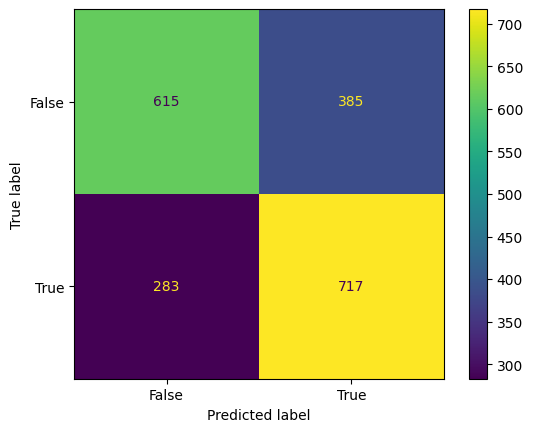

In [22]:
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(1)
    else:
        y_true.append(0)

y_pred = []
for i in cos_sim:
    if i > 0.85:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [3]:
triplet_model = tf.keras.models.load_model('models/model1_cos.h5')

data = next(data_generator(batch_size=1000))

In [12]:
data[0][2].shape

(1000, 90, 173)

63/63 [==============================] - 110s 2s/step


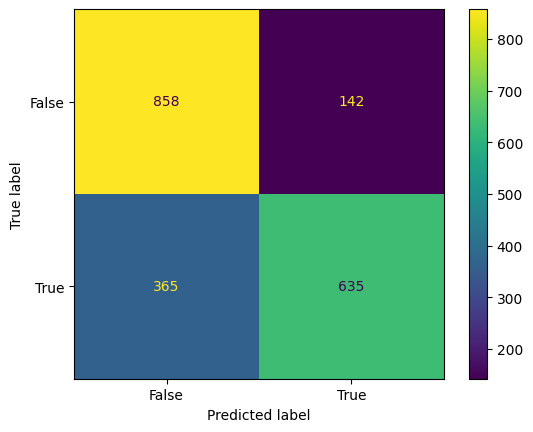

In [23]:
triplet_model = tf.keras.models.load_model('models/model1_cos.h5')

data = next(data_generator(batch_size=1000))

new = []

new.append(np.concatenate((data[0][0], data[0][0])))
new.append(np.concatenate((data[0][1], data[0][2])))
new.append(np.zeros((new[0].shape)))
    
preds = triplet_model.predict(new)

cos_sim = []

for pred in preds:
    anch = pred[:100]
    pos = pred[100:200]
    neg = pred[200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())
    
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(1)
    else:
        y_true.append(0)

y_pred = []
for i in cos_sim:
    if i > 0.85:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

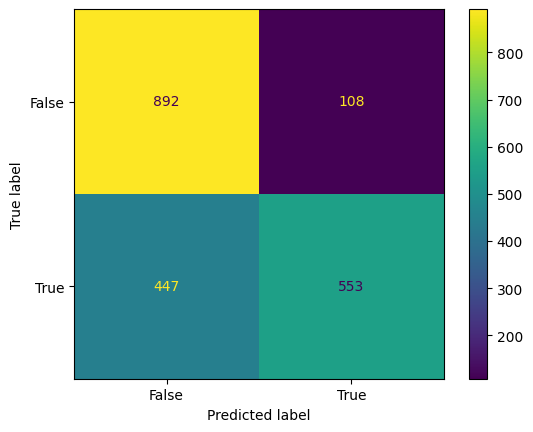

In [25]:
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(1)
    else:
        y_true.append(0)

y_pred = []
for i in cos_sim:
    if i > 0.9:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

63/63 [==============================] - 123s 2s/step


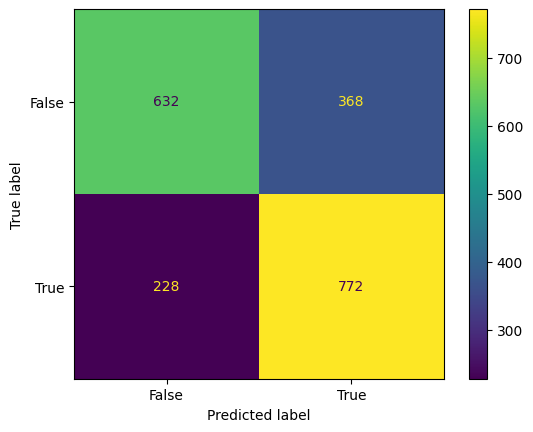

In [26]:
triplet_model = tf.keras.models.load_model('models/model_dropout_cos.h5')

data = next(data_generator(batch_size=1000))

new = []

new.append(np.concatenate((data[0][0], data[0][0])))
new.append(np.concatenate((data[0][1], data[0][2])))
new.append(np.zeros((new[0].shape)))
    
preds = triplet_model.predict(new)

cos_sim = []

for pred in preds:
    anch = pred[:100]
    pos = pred[100:200]
    neg = pred[200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())
    
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(1)
    else:
        y_true.append(0)

y_pred = []
for i in cos_sim:
    if i > 0.85:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

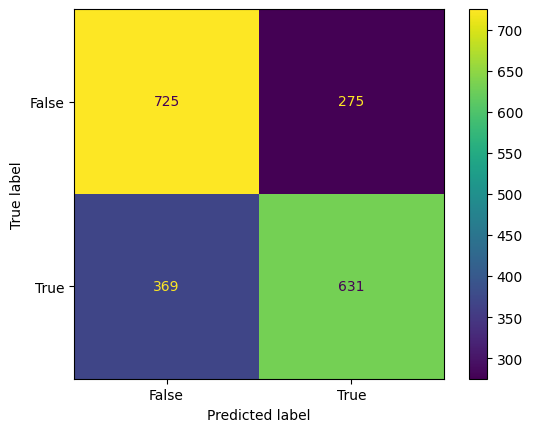

In [28]:
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(1)
    else:
        y_true.append(0)

y_pred = []
for i in cos_sim:
    if i > 0.95:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()